## Imports

In [1]:
import sys
import time
import importlib
import sparse
import datetime
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
local_imports = (
    dbutils,
    data_utils,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)

## Cohort, Outcome and Feature Collection

### 1. Set up a connection to the OMOP CDM database

Parameters for connection to be specified in ./config.py

In [2]:
# database connection
username = config.PG_USERNAME
password = config.PG_PASSWORD
database_name = config.DB_NAME

config_path = 'postgresql://{username}:{password}@{database_name}'.format(
    username = username,
    password = password,
    database_name = database_name
)

# schemas 
schema_name = 'eol_test' # all created tables will be created using this schema

# caching
reset_schema = False # if true, rebuild all data from scratch

# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name)
if reset_schema:
    db.execute(
        'drop schema if exists {} cascade'.format(schema_name)
    )
db.execute(
    'create schema if not exists {}'.format(schema_name)
)

/home/justinl/miniconda3/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:3517: SAWarning: Skipped unsupported reflection of expression-based index idx__loc_source_value
  "expression-based index %s" % idx_name


Executed 1 SQLs


### Build a Cohort for the End of Life Prediction Task

##### Create a Cohort Object that can be constructed as specified by SQL File & Params

In [3]:
cohort_name = '__eol_cohort'
if config.CDM_VERSION == 'v5.3.1':
    cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort_v531.sql'
else:
    cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : cohort_name,
          'schema_name'           : schema_name,
          'aux_data_schema'       : config.CDM_AUX_SCHEMA,
          'training_start_date'   : '2016-01-01',
          'training_end_date'     : '2017-01-01',
          'gap'                   : '3 months',
          'outcome_window'        : '6 months'
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=cohort_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)

##### Build Cohort

In [4]:
cohort.build(db, replace=False)

Table already exists, set replace=True to rebuild


### Get a Time Series of Features for Cohort Members

In [5]:
featureSet = FeatureGenerator.FeatureSet(db)

# Add temporal features
featureSet.add_default_features(
    ['drugs','conditions','procedures','specialty'],
    schema_name,
    cohort_name
)

# Add nontemporal features
featureSet.add_default_features(
    ['age', 'gender'],
    schema_name,
    cohort_name,
    temporal=False
)

In [6]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = config.DEFAULT_SAVE_LOC + 'cache_data_eol_test'
nontemporal_cache_data_path = config.DEFAULT_SAVE_LOC + 'cache_data_eol_test_ntmp'
featureSet.build(cohort, from_cached=False, 
                 cache_file=cache_data_path, 
                 nontemporal_cache_file=nontemporal_cache_data_path)

Data loaded to buffer in 373.53 seconds
Got Unique Concepts and Timestamps in 50.40 seconds
Created Index Mappings in 0.03 seconds
114043
Generated Sparse Representation of Data in 153.52 seconds
Nontemporal data loaded to buffer in 2.92 seconds
Got Unique Nontemporal Concepts in 0.20 seconds
Created Nontemporal Index Mappings in 0.02 seconds
Generated Sparse Representation of Nontemporal Data in 0.16 seconds
CPU times: user 3min 44s, sys: 25.5 s, total: 4min 10s
Wall time: 9min 41s


In [8]:
# If there are only temporal features
'''
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet)
'''

# If there are nontemporal features
outcomes_filt, feature_matrix_3d_transpose, nontemporal_feature_matrix, remap, \
    good_feature_names, nontemporal_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet, include_nontemporal=True)

### Build a Model to Predict End of Life using this data

#### Transform Data to get a vector of counts over 1, 6, 12, 24 and infinity (represented by 10000 days) month windows for each Patient

In [9]:
%%time
feature_matrix_counts, feature_names = data_utils.window_data(
    window_lengths = [30, 180, 365, 730, 10000],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort = cohort,
    featureSet = featureSet
)

CPU times: user 8min 11s, sys: 50.7 s, total: 9min 2s
Wall time: 9min 2s


#### Combine temporal and non-temporal features, if needed
This implementation binarizes the counts of the temporal features using the tr_func function.

In [56]:
def sparse_ufunc(f):
    def wrapper(*a, **k):
        X = a[0]
        if not scipy.sparse.isspmatrix(X):
            raise ValueError
        X2 = X.copy()
        X2.data = f(X2.data, *(a[1:]), **k)
        return X2
    return wrapper

@sparse_ufunc
def tr_func(X, kwarg=1):
    return np.clip(X, 0, kwarg)

# If there are no nontemporal features, binarize the temporal features
'''
full_feature_matrix = tr_func(feature_matrix_counts.T)
'''

# If there are nontemporal features, binarize the temporal features, then combine them
full_feature_matrix = scipy.sparse.hstack((tr_func(feature_matrix_counts.T), nontemporal_feature_matrix))

#### Instantiate, Train and Test Model
In this implementation, we use a standard sklearn Pipeline consisting of a StandardScaler and a LogisticRegression.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler

# Construct train, validate, and test sets
indices = range(len(outcomes_filt))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    full_feature_matrix,
    # feature_matrix_counts.T, 
    outcomes_filt, indices,
    test_size=0.2, random_state=1
)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train,
    # feature_matrix_counts.T, 
    y_train, indices_train,
    test_size=0.3, random_state=1
)

# Train model by hyperparameter search
Cs = [1, 1e-1, 1e-2, 1e-3, 1e-4]
models = []
scores = []
for C in Cs:
    lr = LogisticRegression(
        class_weight='balanced', C=C,
        penalty='l1', fit_intercept=True,
        solver='liblinear', random_state=0,
        verbose=0, max_iter = 200, tol=1e-1
    )
    scaler = StandardScaler(with_mean=False)  # with_mean=False necessary because feature matrices are sparse
    clf = Pipeline([
        ('scaler', scaler),
        ('lr', lr)
    ])
    clf.fit(X_train, y_train)
    pred = clf.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, pred)
    scores.append(score)
    print("C: %.4f, Val AUC: %.2f" % (C, score))
    models.append(clf)
    
# Evaluate selected model
clf = models[np.argmax(scores)]
pred = clf.predict_proba(X_test)[:, 1]
print('Model Test AUC: {0:.2f}'.format(roc_auc_score(y_test, pred)))

C: 1.0000, Val AUC: 0.57
C: 0.1000, Val AUC: 0.61
C: 0.0100, Val AUC: 0.67
C: 0.0010, Val AUC: 0.81
C: 0.0001, Val AUC: 0.67
Model Test AUC: 0.82


#### Evaluate Model : RoC and Precision-Recall Curves

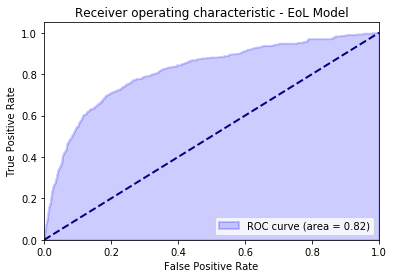

In [41]:
fpr, tpr, _ = roc_curve(y_test, pred)
plt.figure()
lw = 2
plt.fill_between(fpr, tpr, color='b', alpha = 0.2,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - EoL Model')
plt.legend(loc="lower right")
plt.show()

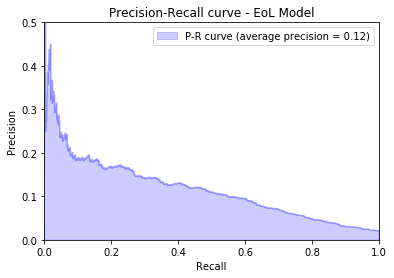

In [42]:
precision, recall, _ = precision_recall_curve(y_test, pred)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(
    recall, precision, alpha=0.2, color='b',
    label='P-R curve (average precision = %0.2f)' % average_precision
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.5])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall curve - EoL Model')
plt.show()

#### Evaluate Model : Extract Feature Weights

In [43]:
feature_weights = pd.DataFrame({
    'feature_name': feature_names + nontemporal_feature_names,
    'feature_weight': list(clf.get_params()['lr'].coef_[0])
}).sort_values(by='feature_weight')
pd.set_option('display.max_colwidth', -1)

/home/justinl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [44]:
feature_weights.tail(20)

,feature_name,feature_weight
111895,436222 - condition - Altered mental status - 730 days,0.038231
121137,2102077 - procedure - Debridement of nail(s) by any method(s); 6 or more - 10000 days,0.040244
124577,"2211401 - procedure - Computed tomography, cervical spine; without contrast material - 10000 days",0.040795
103208,38003845 - specialty - Emergency Medicine - 730 days,0.041862
46764,4022076 - condition - Patient dependence on care provider - 180 days,0.041948
125656,"2514406 - procedure - Initial hospital care, per day, for the evaluation and management of a patient, which requires these 3 key components: A comprehensive history; A comprehensive examination; and Medical decision making of high complexity. Counseling and/or coordination of - 10000 days",0.042083
38474,"2314229 - procedure - Chemotherapy administration, intravenous infusion technique; up to 1 hour, single or initial substance/drug - 180 days",0.042360
9755,255573 - condition - Chronic obstructive lung disease - 30 days,0.044343
118733,19123989 - drug - Albuterol 0.83 MG/ML Inhalation Solution - 10000 days,0.046932
140907,436222 - condition - Altered mental status - 10000 days,0.049140


In [45]:
feature_weights.head(20)

,feature_name,feature_weight
138416,"42627987 - procedure - Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (CAD) when performed - 10000 days",-0.173902
120918,"2100978 - procedure - Anesthesia for lower intestinal endoscopic procedures, endoscope introduced distal to duodenum - 10000 days",-0.075298
125555,"2314290 - procedure - Manual therapy techniques (eg, mobilization/ manipulation, manual lymphatic drainage, manual traction), 1 or more regions, each 15 minutes - 10000 days",-0.060973
80392,"42627987 - procedure - Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (CAD) when performed - 365 days",-0.053252
145060,Age at end_date,-0.050525
109404,"42627987 - procedure - Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (CAD) when performed - 730 days",-0.047982
132229,38004450 - specialty - Anesthesiology - 10000 days,-0.044001
95844,"2211809 - procedure - Computer-aided detection (computer algorithm analysis of digital image data for lesion detection) with further review for interpretation, with or without digitization of film radiographic images; screening mammography (List separately in addition to code - 730 days",-0.042069
96537,"2314284 - procedure - Therapeutic procedure, 1 or more areas, each 15 minutes; therapeutic exercises to develop strength and endurance, range of motion and flexibility - 730 days",-0.035257
142175,442588 - condition - Obstructive sleep apnea syndrome - 10000 days,-0.034087


In [46]:
for category in ['procedure', 'condition', 'drug', 'specialty']:
    print('Number of nonzero {} feature weights : {}'.format(
        category,
        sum(feature_weights.loc[
            [i for i,j in enumerate(feature_names) if '- ' + category + ' -' in j]
        ]['feature_weight'] != 0)
    ))

Number of nonzero procedure feature weights : 363
Number of nonzero condition feature weights : 419
Number of nonzero drug feature weights : 248
Number of nonzero specialty feature weights : 13
